In [1]:
import yaml
import sys
import os
sys.path.append('..')

from wildlife_datasets import analysis, datasets, loader

datasets_cloud = '/Users/amee/Library/Mobile Documents/com~apple~CloudDocs/wildlife-datasets/'
path = os.path.join(datasets_cloud, 'GiraffeZebraID')
# path = '/Users/amee/Documents/code/master-thesis/datasets/GiraffeZebraID/'

datasets.GiraffeZebraID.get_data(path)


DATASET GiraffeZebraID: DOWNLOADING STARTED.


gzgc.coco.tar.gz:   0%|          | 14.2M/10.4G [00:02<32:43, 5.31MB/s]    


KeyboardInterrupt: 

In [ ]:

dataset = datasets.GiraffeZebraID(path)

In [ ]:
data = WildlifeReidDataModule(metadata=dataset.df, config=config)

In [1]:
import pandas as pd

csv_path = '../dataset/dataframe/cache_BirdIndividualID.csv'
metadata = pd.read_csv(csv_path)

# metadata = metadata[metadata['identity'] != 'unknown']
# save to csv
# metadata.to_csv(csv_path, index=False)

metadata

,image_id,identity,path,species,original_split,bbox,segmentation,height,width,area,iscrowd,width.1,height.1
0,00239fb5101d581c,0700EE16B2,Original_pictures/IndividualID/sociable_weaver...,sociable_weavers,train,"[480, 256, 237, 437]","[[484, 256, 480, 260, 480, 396, 484, 412, 536,...",768,1024,NaN,NaN,1024,768
1,00265006a4e647bc,011016BE08,Original_pictures/IndividualID/sociable_weaver...,sociable_weavers,train,"[816, 128, 205, 213]","[[840, 132, 832, 148, 816, 164, 816, 180, 824,...",768,1024,NaN,NaN,1024,768
2,00392a41c0880340,011016BE08,Original_pictures/IndividualID/sociable_weaver...,sociable_weavers,train,"[224, 448, 213, 317]","[[260, 464, 236, 488, 224, 508, 224, 576, 240,...",768,1024,NaN,NaN,1024,768
3,00698098dd8a3954,011016F8EC,Original_pictures/IndividualID/sociable_weaver...,sociable_weavers,train,"[608, 192, 253, 489]","[[624, 192, 612, 200, 612, 216, 608, 220, 608,...",768,1024,NaN,NaN,1024,768
4,0073504a926993d7,0700EE27D7,Original_pictures/IndividualID/sociable_weaver...,sociable_weavers,val,"[464, 192, 329, 469]","[[464, 208, 468, 228, 480, 236, 504, 240, 528,...",768,1024,NaN,NaN,1024,768
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2870,07fecee35e61e376,011017686F,Original_pictures/IndividualID/great_tits/Val/...,great_tits,val,"[1488.0, 324.0, 429.0, 171.0]","[[1680.0, 324.0, 1677.0, 327.0, 1671.0, 327.0,...",1080,1920,50562.0,0.0,1920,1080
2871,0881657fd45726f5,0110178989,Original_pictures/IndividualID/great_tits/Trai...,great_tits,train,"[660.0, 420.0, 333.0, 399.0]","[[903.0, 420.0, 894.0, 429.0, 891.0, 429.0, 88...",1080,1920,45958.0,0.0,1920,1080
2872,0883d56a3889fa4d,0417D30D92,Original_pictures/IndividualID/sociable_weaver...,sociable_weavers,train,"[404.79998779296875, 134.39999389648438, 187.2...","[[480.0, 134.39999389648438, 478.3999938964844...",768,1024,54259.0,0.0,1024,768
2873,097640d8e380614c,01103F3E1B,Original_pictures/IndividualID/sociable_weaver...,sociable_weavers,val,"[518.4000244140625, 192.0, 144.0, 403.20001220...","[[545.5999755859375, 192.0, 544.0, 193.6000061...",768,1024,38373.0,0.0,1024,768


In [15]:
import pandas as pd
import json
from pycocotools import mask as coco_mask
import numpy as np
import cv2
import csv

def decode_rle(rle_data):
    """
    Decodes COCO compressed RLE format into a binary mask.
    """
    return coco_mask.decode(rle_data)

def smooth_mask(binary_mask, kernel_size=(5, 5), sigma=1.0):
    """
    Applies Gaussian blurring to smooth the binary mask.
    """
    smoothed_mask = cv2.GaussianBlur(binary_mask.astype(np.float32), kernel_size, sigma)
    _, binary_smoothed = cv2.threshold(smoothed_mask, 0.5, 1, cv2.THRESH_BINARY)
    return binary_smoothed.astype(np.uint8)

def extract_contours(binary_mask):
    """
    Extracts the contours of the binary mask.
    """
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return [contour for contour in contours if len(contour) > 1]  # Filter out empty/invalid contours


def simplify_contours(contours, epsilon=3.0):
    """
    Applies polygon approximation to simplify contours.
    """
    simplified_contours = []
    for contour in contours:
        # Check if the contour has at least one point
        if len(contour) < 2:
            continue
        # Ensure contour is in the correct data type for approxPolyDP
        contour_array = np.array(contour, dtype=np.int32)
        simplified_contour = cv2.approxPolyDP(contour_array, epsilon, closed=True)
        simplified_contours.append(simplified_contour.reshape(-1, 2).tolist())
    return simplified_contours

# Read, process, and overwrite each row directly in csv_path
with open(csv_path, newline='') as infile:
    reader = csv.DictReader(infile)
    
    # Check for headers
    if reader.fieldnames is None:
        raise ValueError("CSV file is missing headers.")
    
    # Prepare rows with added 'decoded_segmentation' field
    updated_rows = []
    for row in reader:
        segmentation = row["segmentation"]
        
        # Skip empty segmentation fields
        if not segmentation:
            row['segmentation'] = None
            updated_rows.append(row)
            continue
        
        if isinstance(segmentation, str):
            try:
                # Replace single quotes with double quotes for JSON compliance
                segmentation = json.loads(segmentation.replace("'", "\""))
            except json.JSONDecodeError:
                print(f"Skipping row due to JSON parse error: {row}")
                row['segmentation'] = None
                updated_rows.append(row)
                continue
        
        # Check if the segmentation is in COCO RLE format
        if isinstance(segmentation, dict) and "size" in segmentation and "counts" in segmentation:
            # Decode the RLE to get the binary mask
            binary_mask = decode_rle(segmentation)
            
            # Smooth and downsample the mask
            smoothed_mask = smooth_mask(binary_mask)            
            # Extract and simplify contours
            contours = extract_contours(smoothed_mask)
            simplified_contours = simplify_contours(contours)
            
            # Flatten and store the simplified coordinates
            if simplified_contours:
                flat_list = [coord for contour in simplified_contours for point in contour for coord in point]
                row['segmentation'] = [flat_list]
                print(row['segmentation'])
            else:
                row['segmentation'] = None  # Handle cases where no valid contours are found
        else:
            # If not RLE, set None or handle non-RLE formats here
            row['segmentation'] = None
        
        # Add the processed row to the list
        updated_rows.append(row)

# Overwrite the CSV file with updated data
with open(csv_path, 'w', newline='') as outfile:
    fieldnames = updated_rows[0].keys()  # Use keys from the first row to define headers
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(updated_rows)

[[484, 256, 480, 260, 480, 396, 484, 412, 536, 500, 560, 524, 588, 540, 636, 596, 640, 612, 656, 632, 656, 644, 676, 680, 676, 691, 692, 692, 704, 684, 712, 668, 716, 644, 712, 628, 684, 584, 684, 564, 668, 528, 668, 488, 656, 472, 652, 444, 636, 416, 636, 404, 616, 368, 592, 340, 588, 328, 544, 288, 528, 260, 520, 256]]
[[840, 132, 832, 148, 816, 164, 816, 180, 824, 188, 836, 188, 848, 200, 864, 228, 864, 248, 876, 260, 884, 280, 932, 328, 981, 339, 1000, 312, 1008, 272, 1020, 263, 1020, 177, 980, 160, 936, 160, 900, 128, 848, 128]]
[[260, 464, 236, 488, 224, 508, 224, 576, 240, 608, 240, 648, 256, 680, 260, 763, 435, 764, 432, 728, 428, 724, 428, 688, 412, 648, 408, 620, 392, 584, 364, 548, 344, 532, 328, 504, 328, 488, 347, 455, 328, 448, 300, 448]]
[[624, 192, 612, 200, 612, 216, 608, 220, 608, 376, 636, 420, 656, 464, 704, 504, 732, 540, 736, 552, 752, 568, 768, 600, 780, 612, 784, 632, 804, 667, 824, 680, 840, 680, 856, 664, 860, 640, 844, 612, 844, 600, 832, 584, 828, 560, 816, 

In [4]:
import sys
sys.path.append('..')
from models.triplet_loss_model import TripletModel
from data.wildlife_dataset import WildlifeDataModule
from wildlife_datasets import datasets

dataset = datasets.BirdIndividualID('/Users/amee/Documents/code/master-thesis/datasets/BirdIndividualID/')
metadata = dataset.df

data = WildlifeDataModule(data_dir='/Users/amee/Documents/code/master-thesis/datasets/BirdIndividualID/', 
                              metadata=metadata[:], 
                              size = 224, 
                              preprocess_lvl=3, 
                              cache_path='/Users/amee/Documents/code/master-thesis/EagleID/dataset/dataframe/cache_BirdIndividualID.csv', 
                              animal_cat = 'bird', 
                              only_cache=True)

No segmentation data found: Not a list after conversion.
No segmentation data found: Not a list after conversion.
No segmentation data found: Not a list after conversion.
No segmentation data found: Not a list after conversion.
No segmentation data found: Not a list after conversion.
No segmentation data found: Not a list after conversion.
No segmentation data found: Not a list after conversion.
No segmentation data found: Not a list after conversion.
No segmentation data found: Not a list after conversion.
No segmentation data found: Not a list after conversion.
No segmentation data found: Not a list after conversion.
No segmentation data found: Not a list after conversion.
No segmentation data found: Not a list after conversion.
No segmentation data found: Not a list after conversion.
No segmentation data found: Not a list after conversion.
No segmentation data found: Not a list after conversion.
No segmentation data found: Not a list after conversion.
No segmentation data found: Not

Batch Size: 8
Image Shape: torch.Size([8, 4, 224, 224])
Labels Shape: torch.Size([8])


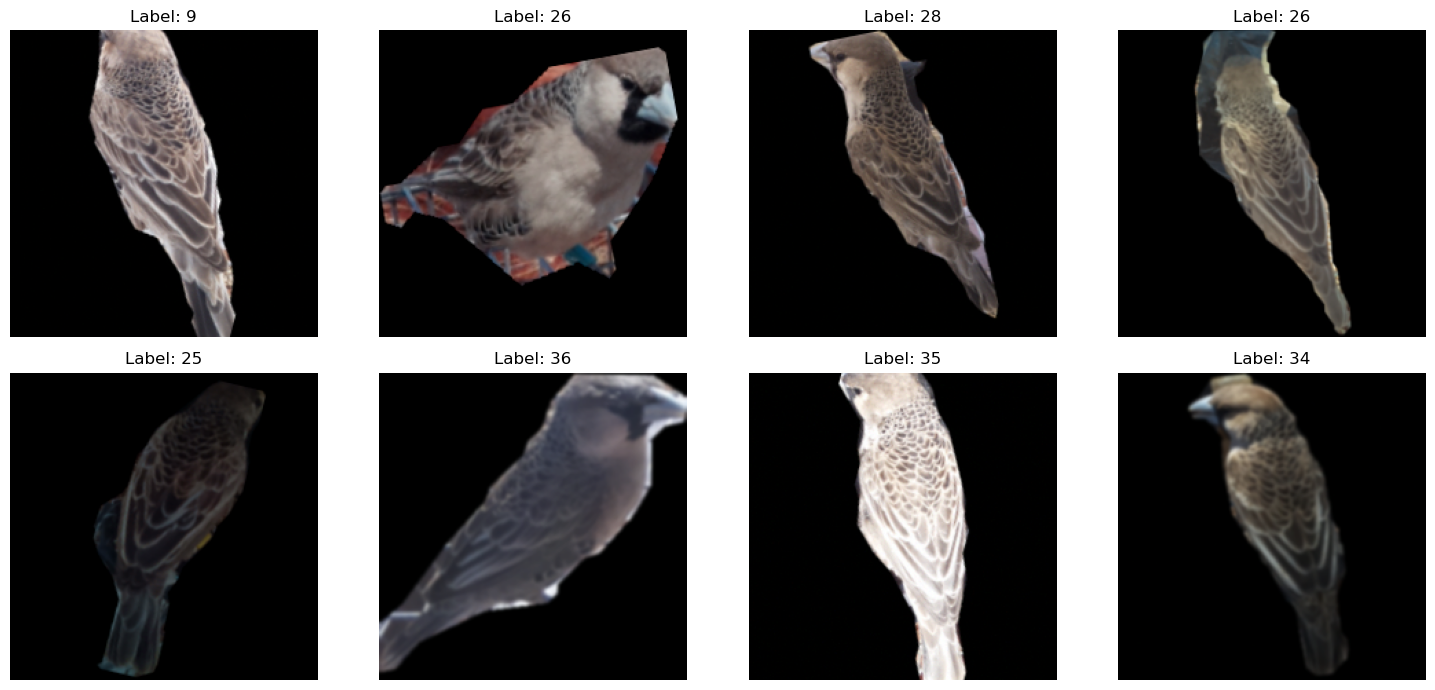

In [3]:

import matplotlib.pyplot as plt
import numpy as np
from data.transforms import denormalize

mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]

train_dataloader = data.train_dataloader()

# Fetch a batch of images (assuming batch size is 8 for example)
batch = next(iter(train_dataloader))
images,labels = batch
print("Batch Size:", images.size(0))
print("Image Shape:", images.shape)
print("Labels Shape:", labels.shape)

# Extract images and labels from the batch
images, labels = batch  # This assumes batch is structured as (images, labels)

# Plot the images
fig, axes = plt.subplots(2, 4, figsize=(15, 7))
axes = axes.flatten()

for i in range(8):  # Assuming batch size is 8
    # image_np = unnormalize(images[i], mean, std).permute(1, 2, 0).numpy()  # [:3] selects RGB channels

    image_np = images[i].numpy()  # Convert from PyTorch tensor to numpy array
    image_np = denormalize(image_np, mean, std)  # Denormalize the image

    image_np = np.transpose(image_np, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C) for plotting
    label = labels[i].item()  # Convert label tensor to Python scalar using .item()
    ax = axes[i]
    ax.imshow(image_np)
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Batch Size: 8
Image Shape: torch.Size([8, 4, 224, 224])
Labels Shape: torch.Size([8])


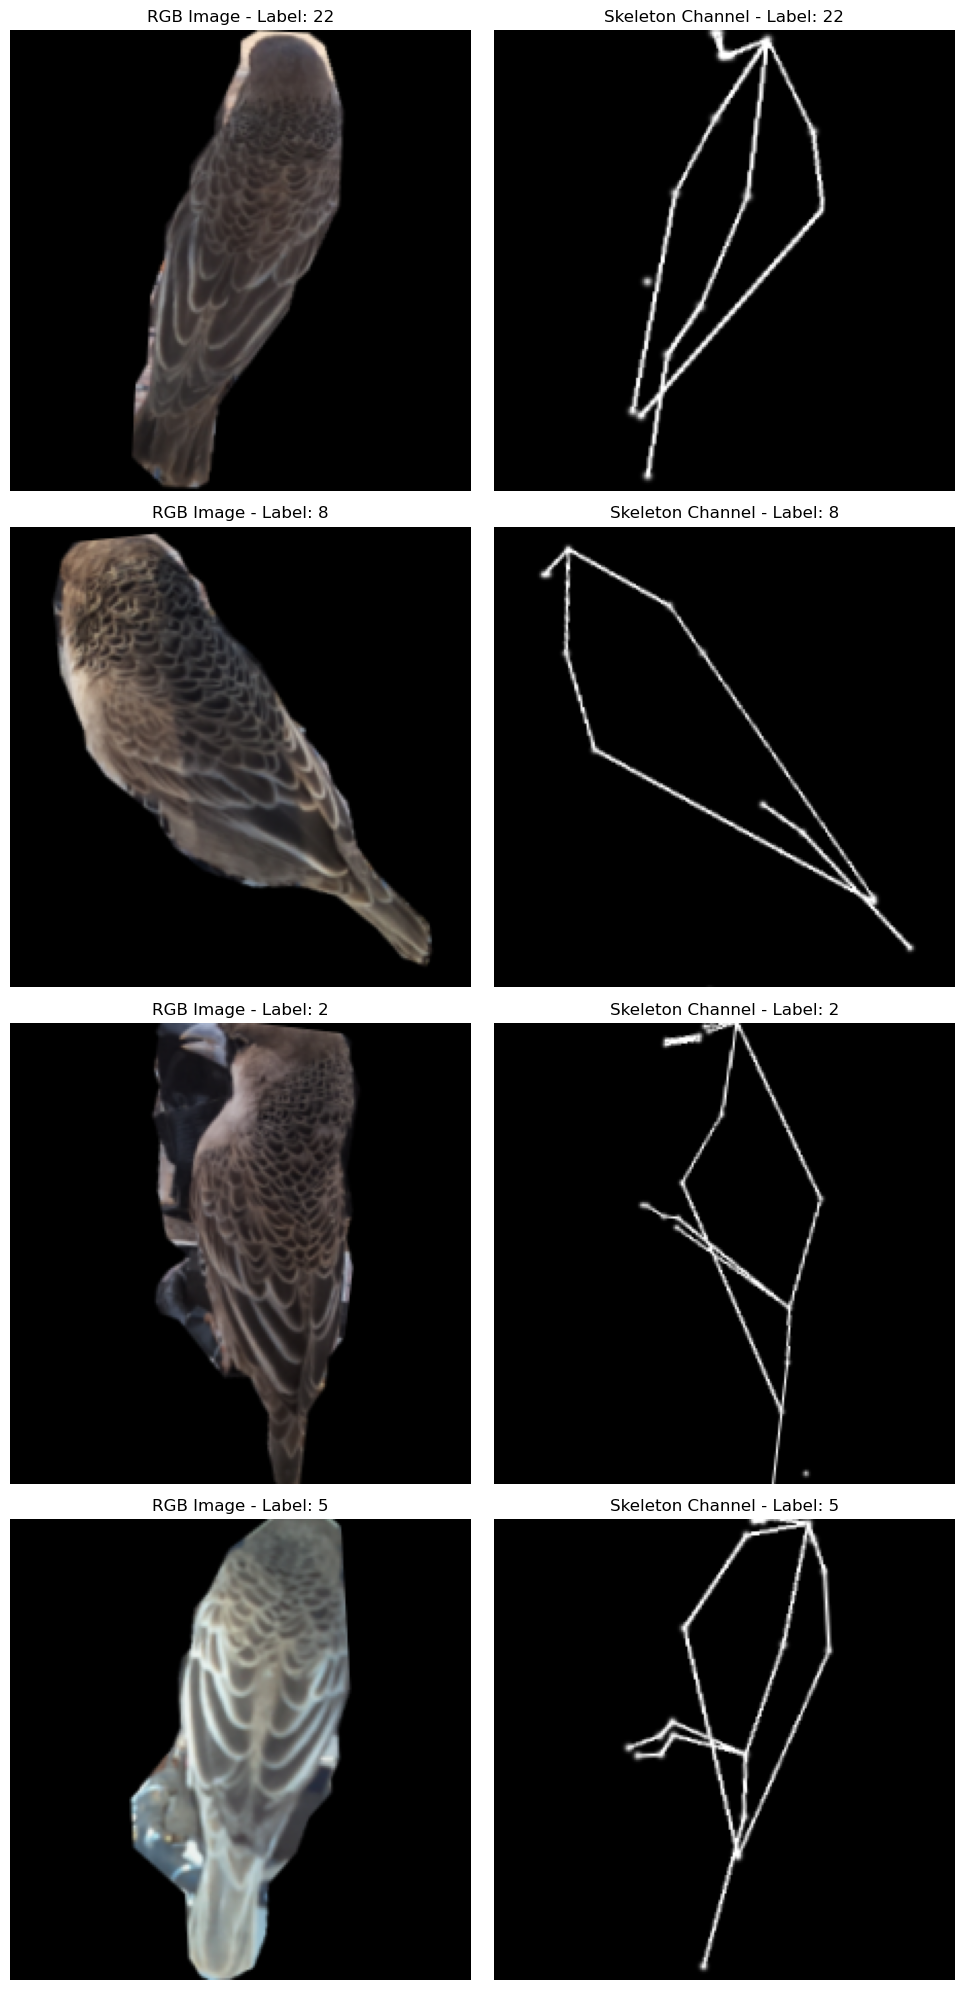

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from data.data_utils import unnormalize

mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]


train_dataloader = data.train_dataloader()

batch = next(iter(train_dataloader))
images, labels = batch

print("Batch Size:", images.size(0))
print("Image Shape:", images.shape)
print("Labels Shape:", labels.shape)

# Plot the images and their skeletons side by side
fig, axes = plt.subplots(4, 2, figsize=(10, 20))  # 4 rows, 2 columns (RGB and skeleton for each image)
axes = axes.flatten()

for i in range(4):  # Assuming batch size is at least 4
    # Unnormalize the RGB part
    rgb_image = unnormalize(images[i], mean, std).permute(1, 2, 0).numpy()  # First 3 channels (RGB)
    skeleton_image = images[i][3].cpu().numpy()  # 4th channel (Skeleton)

    # Plot RGB image
    ax_rgb = axes[i * 2]
    ax_rgb.imshow(np.clip(rgb_image, 0, 1))  # Clip values to [0, 1] for valid image display
    ax_rgb.set_title(f'RGB Image - Label: {labels[i].item()}')
    ax_rgb.axis('off')

    # Plot Skeleton image (grayscale)
    ax_skel = axes[i * 2 + 1]
    ax_skel.imshow(skeleton_image, cmap='gray')  # Plot skeleton channel as a grayscale image
    ax_skel.set_title(f'Skeleton Channel - Label: {labels[i].item()}')
    ax_skel.axis('off')

plt.tight_layout()
plt.show()

In [7]:
import pandas as pd
import os
cache_raptors = pd.read_csv('/Users/amee/Documents/code/master-thesis/EagleID/dataset/dataframe/cache_raptors.csv')
cache_birdIndividual = pd.read_csv('/Users/amee/Documents/code/master-thesis/EagleID/dataset/dataframe/cache_BirdIndividualID.csv')

cache_raptors['wildlife_name'] = 'raptors'
cache_raptors['path'] = cache_raptors['path'].apply(lambda x: os.path.join('raptor_individuals_cropped', x))


cache_birdIndividual['wildlife_name'] = 'BirdIndividualID'
cache_birdIndividual['path'] = cache_birdIndividual['path'].apply(lambda x: os.path.join('BirdIndividualID', x))

cache_birds = pd.concat([cache_raptors, cache_birdIndividual], ignore_index=True)
cache_birds.to_csv('/Users/amee/Documents/code/master-thesis/EagleID/dataset/dataframe/cache_birds.csv', index=False)